In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [115]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [119]:
fixed_noise = tf.random.normal([batch_size, 128])

In [120]:
class SaveImagesCallback(Callback):
    def __init__(self, logdir):
        self.logdir = Path(logdir)
        
        self.logdir.mkdir(exist_ok=True, parents=True)
        
        
    def on_epoch_end(self, epoch, logs= None):
        generator = self.model.generator
 
        predictions = generator(fixed_noise, training=False)
        pred_16_index = np.random.choice(np.array(list(range(predictions.shape[0]))), size= 16)
        predictions = np.array([predictions[x, :, :, :] for x in pred_16_index])
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(np.asarray(predictions[i, :, :, :] * 255.0, dtype= np.uint8), cmap='gray')
            plt.axis('off')

        plt.savefig(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')
        plt.show()

In [121]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = self.batch_size
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

Epoch 1/500
100/100 [==============================] - 4s 27ms/step - d_loss: 0.6073 - g_loss: 1.0700


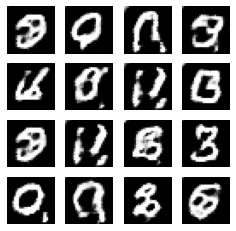

Epoch 2/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5829 - g_loss: 1.1054


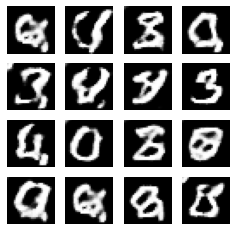

Epoch 3/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5861 - g_loss: 1.1135


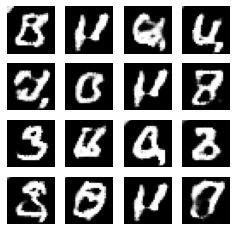

Epoch 4/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5819 - g_loss: 1.1407


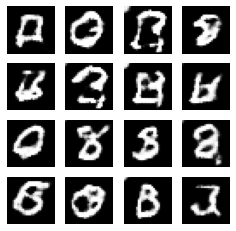

Epoch 5/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6044 - g_loss: 1.1064


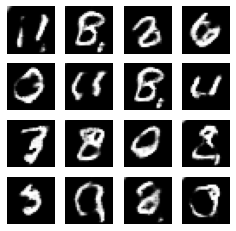

Epoch 6/500
100/100 [==============================] - 3s 27ms/step - d_loss: 0.5860 - g_loss: 1.0506


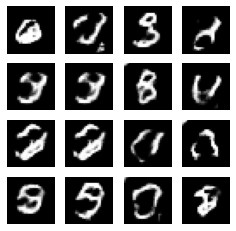

Epoch 7/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5910 - g_loss: 1.0672


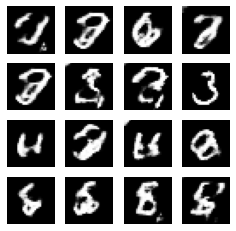

Epoch 8/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5791 - g_loss: 1.0782


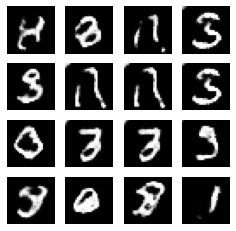

Epoch 9/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5867 - g_loss: 1.0574


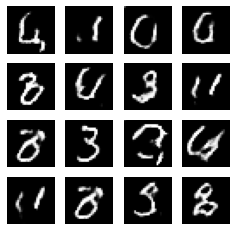

Epoch 10/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5786 - g_loss: 1.1535


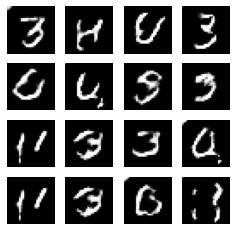

Epoch 11/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5912 - g_loss: 1.1119


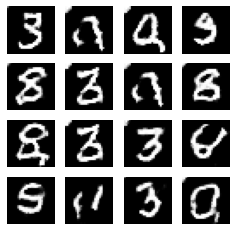

Epoch 12/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5904 - g_loss: 1.1111


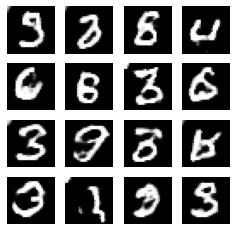

Epoch 13/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5829 - g_loss: 1.0861


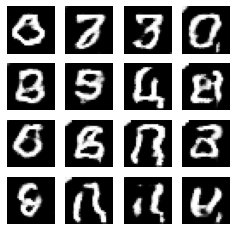

Epoch 14/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5922 - g_loss: 1.0871


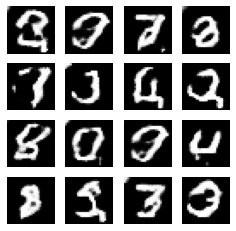

Epoch 15/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5830 - g_loss: 1.1282


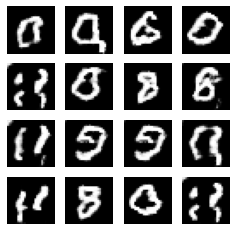

Epoch 16/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5824 - g_loss: 1.0728


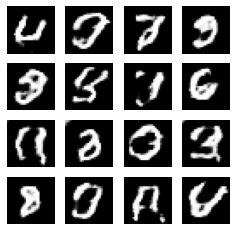

Epoch 17/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5815 - g_loss: 1.0724


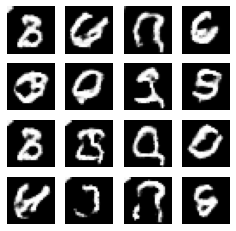

Epoch 18/500
100/100 [==============================] - 3s 29ms/step - d_loss: 0.5793 - g_loss: 1.0939


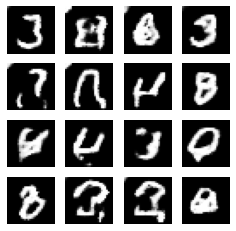

Epoch 19/500
100/100 [==============================] - 3s 30ms/step - d_loss: 0.5662 - g_loss: 1.1299


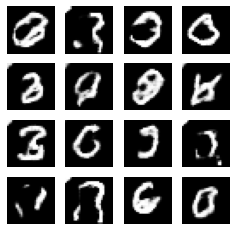

Epoch 20/500
100/100 [==============================] - 3s 28ms/step - d_loss: 0.5789 - g_loss: 1.0937


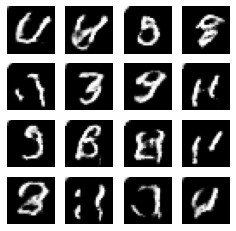

Epoch 21/500
100/100 [==============================] - 3s 29ms/step - d_loss: 0.5810 - g_loss: 1.0925


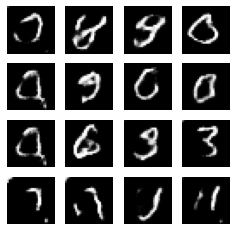

Epoch 22/500
100/100 [==============================] - 3s 30ms/step - d_loss: 0.5709 - g_loss: 1.1367


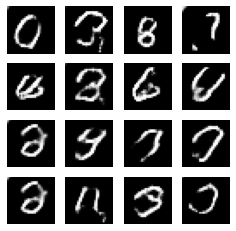

Epoch 23/500
100/100 [==============================] - 3s 30ms/step - d_loss: 0.5797 - g_loss: 1.2505


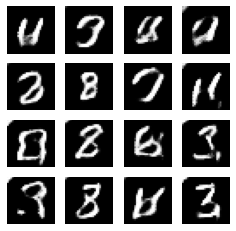

Epoch 24/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5726 - g_loss: 1.1405


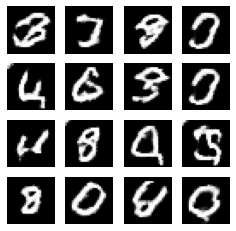

Epoch 25/500
100/100 [==============================] - 3s 30ms/step - d_loss: 0.5899 - g_loss: 1.0845


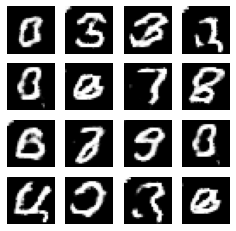

Epoch 26/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5713 - g_loss: 1.0957


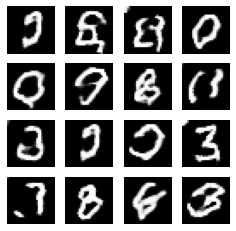

Epoch 27/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5705 - g_loss: 1.0785


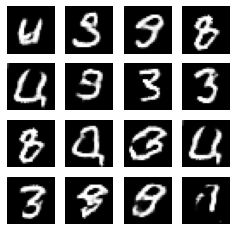

Epoch 28/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5752 - g_loss: 1.0609


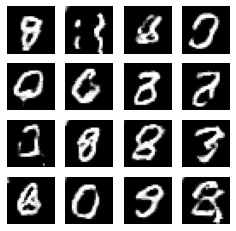

Epoch 29/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5807 - g_loss: 1.0884


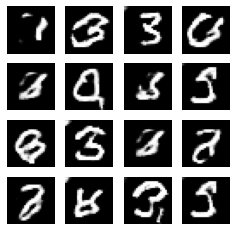

Epoch 30/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5749 - g_loss: 1.1047


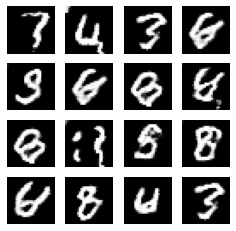

Epoch 31/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5716 - g_loss: 1.1014


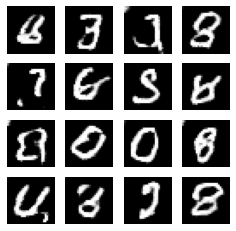

Epoch 32/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5710 - g_loss: 1.0772


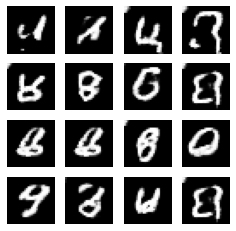

Epoch 33/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5701 - g_loss: 1.0836


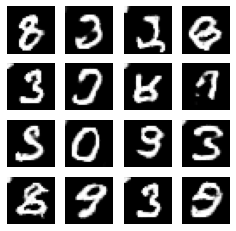

Epoch 34/500
100/100 [==============================] - 3s 30ms/step - d_loss: 0.5794 - g_loss: 1.1279


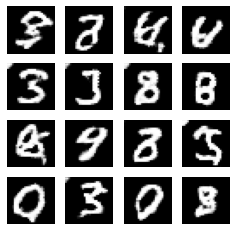

Epoch 35/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5580 - g_loss: 1.1102


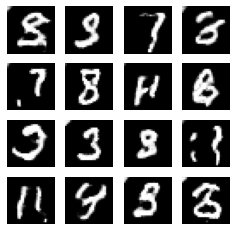

Epoch 36/500
100/100 [==============================] - 3s 31ms/step - d_loss: 0.5654 - g_loss: 1.0757


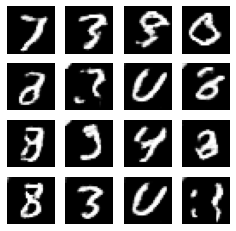

Epoch 37/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5683 - g_loss: 1.0501


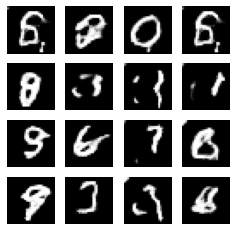

Epoch 38/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5707 - g_loss: 1.0520


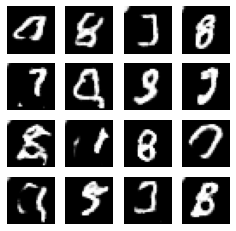

Epoch 39/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5704 - g_loss: 1.0824


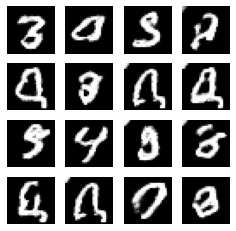

Epoch 40/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5635 - g_loss: 1.1188


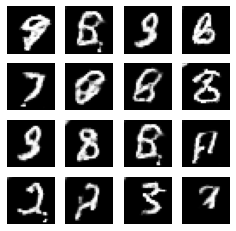

Epoch 41/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5729 - g_loss: 1.0872


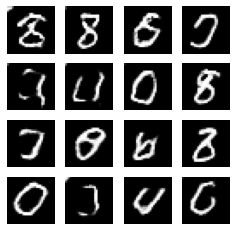

Epoch 42/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5681 - g_loss: 1.0648


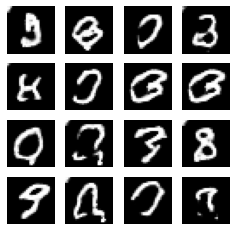

Epoch 43/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5770 - g_loss: 1.0547


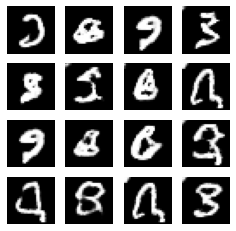

Epoch 44/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5632 - g_loss: 1.1032


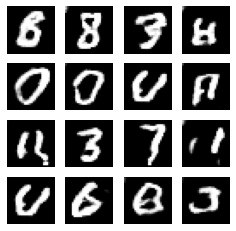

Epoch 45/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5632 - g_loss: 1.1529


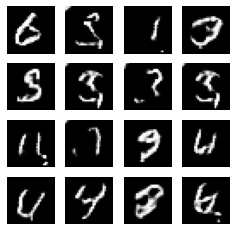

Epoch 46/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5672 - g_loss: 1.1118


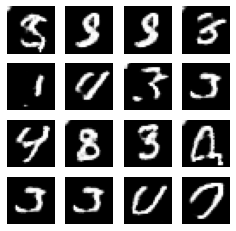

Epoch 47/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5732 - g_loss: 1.0617


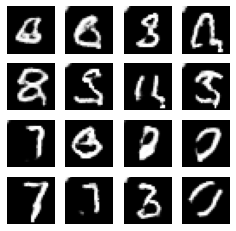

Epoch 48/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5707 - g_loss: 1.0380


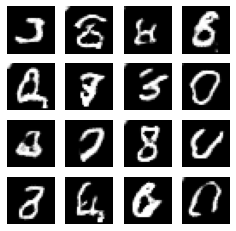

Epoch 49/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5756 - g_loss: 1.0238


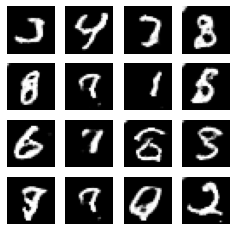

Epoch 50/500
100/100 [==============================] - 3s 32ms/step - d_loss: 0.5786 - g_loss: 1.0192


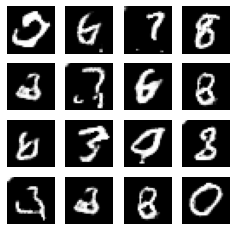

Epoch 51/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5837 - g_loss: 1.0208


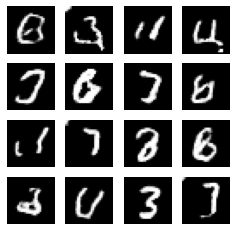

Epoch 52/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5857 - g_loss: 1.0256


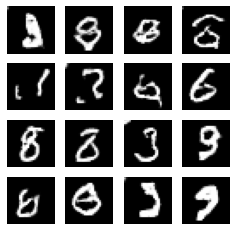

Epoch 53/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5865 - g_loss: 1.0028


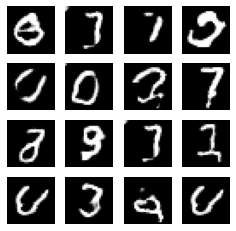

Epoch 54/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5907 - g_loss: 1.0047


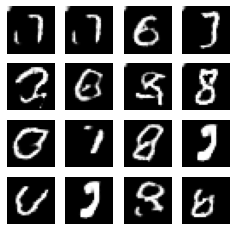

Epoch 55/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.5870 - g_loss: 1.0023


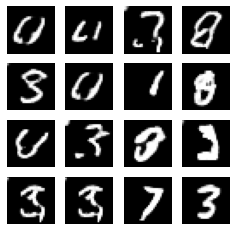

Epoch 56/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.5927 - g_loss: 1.0075


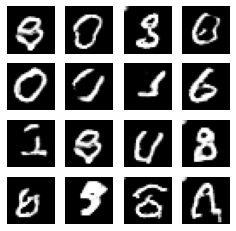

Epoch 57/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5933 - g_loss: 1.0051


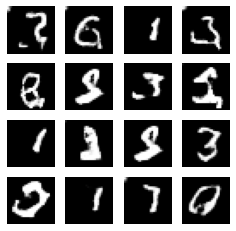

Epoch 58/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.5904 - g_loss: 1.0086


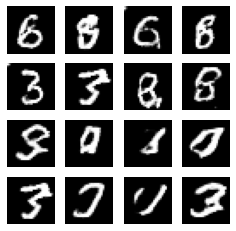

Epoch 59/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.5926 - g_loss: 1.0157


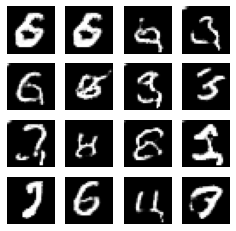

Epoch 60/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5922 - g_loss: 1.0217


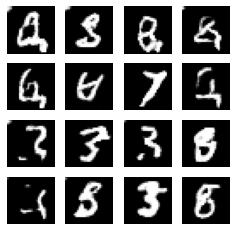

Epoch 61/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5918 - g_loss: 1.0126


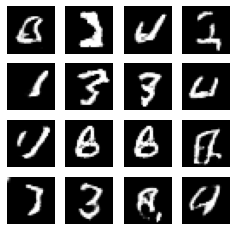

Epoch 62/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5970 - g_loss: 1.0135


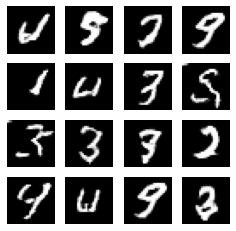

Epoch 63/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.5942 - g_loss: 0.9948


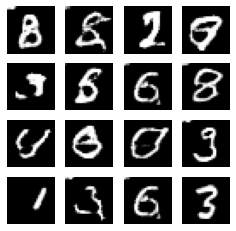

Epoch 64/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6024 - g_loss: 0.9903


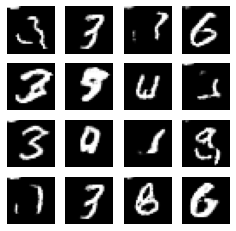

Epoch 65/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5981 - g_loss: 0.9871


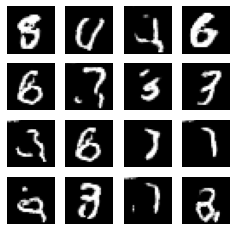

Epoch 66/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.5978 - g_loss: 0.9865


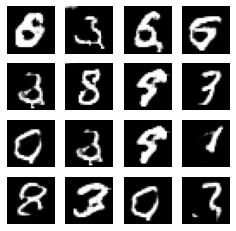

Epoch 67/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.5988 - g_loss: 1.0056


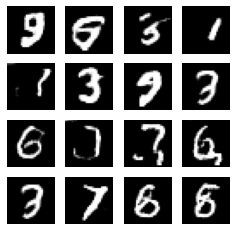

Epoch 68/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6009 - g_loss: 0.9991


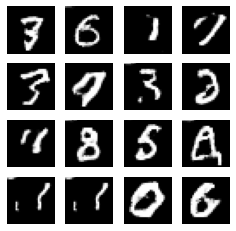

Epoch 69/500
100/100 [==============================] - 4s 36ms/step - d_loss: 0.5990 - g_loss: 1.0117


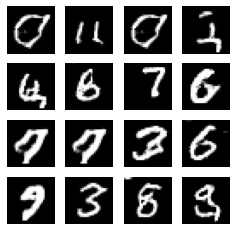

Epoch 70/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5982 - g_loss: 0.9948


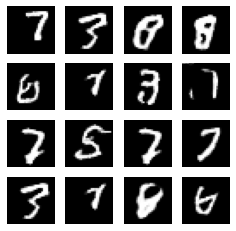

Epoch 71/500
100/100 [==============================] - 4s 44ms/step - d_loss: 0.6016 - g_loss: 0.9843


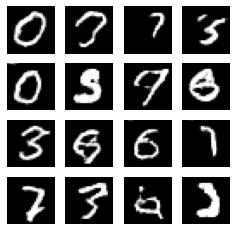

Epoch 72/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6033 - g_loss: 0.9778


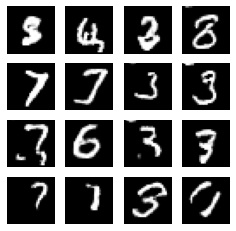

Epoch 73/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.5994 - g_loss: 0.9743


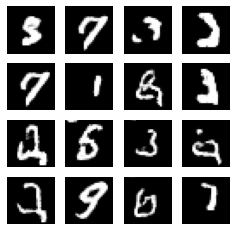

Epoch 74/500
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6043 - g_loss: 0.9725


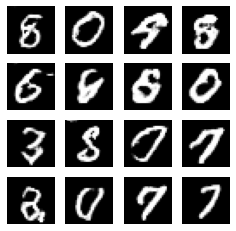

Epoch 75/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6046 - g_loss: 0.9673


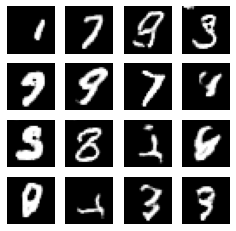

Epoch 76/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6062 - g_loss: 0.9834


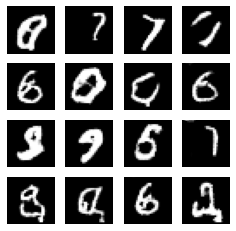

Epoch 77/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6062 - g_loss: 0.9729


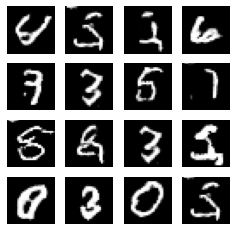

Epoch 78/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6064 - g_loss: 0.9672


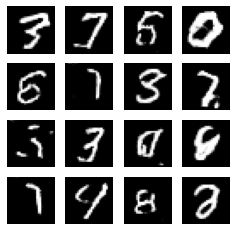

Epoch 79/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6057 - g_loss: 0.9672


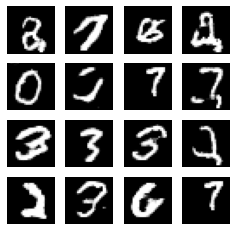

Epoch 80/500
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6061 - g_loss: 0.9755


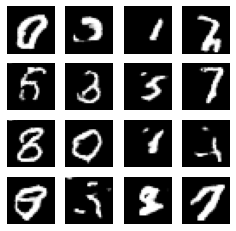

Epoch 81/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6060 - g_loss: 0.9801


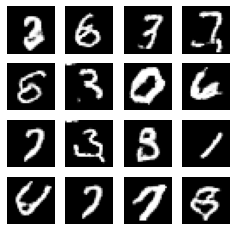

Epoch 82/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6090 - g_loss: 0.9883


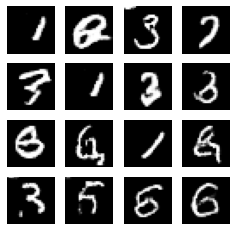

Epoch 83/500
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6060 - g_loss: 0.9686


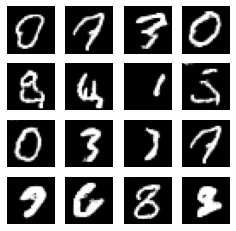

Epoch 84/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6063 - g_loss: 0.9733


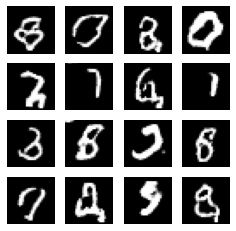

Epoch 85/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6044 - g_loss: 0.9769


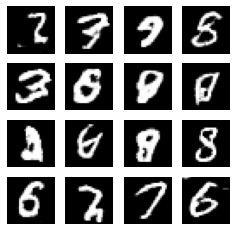

Epoch 86/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6071 - g_loss: 0.9657


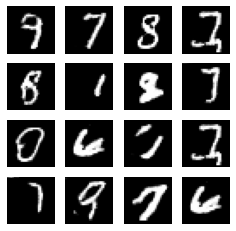

Epoch 87/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6090 - g_loss: 0.9753


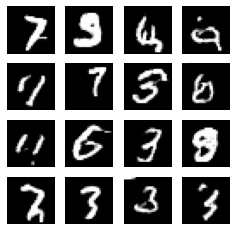

Epoch 88/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6067 - g_loss: 0.9680


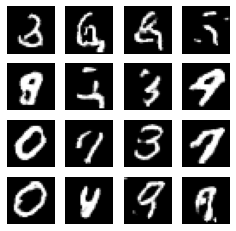

Epoch 89/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6108 - g_loss: 0.9723


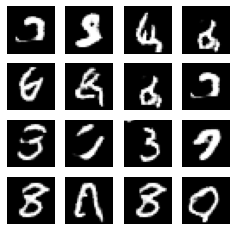

Epoch 90/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6081 - g_loss: 0.9564


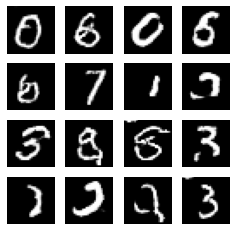

Epoch 91/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6092 - g_loss: 0.9663


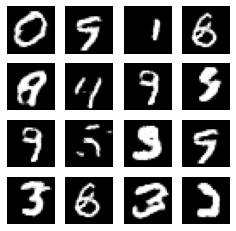

Epoch 92/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6124 - g_loss: 0.9738


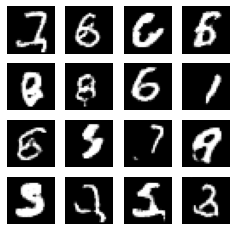

Epoch 93/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6089 - g_loss: 0.9642


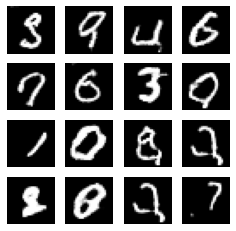

Epoch 94/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6106 - g_loss: 0.9581


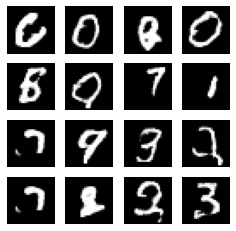

Epoch 95/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6086 - g_loss: 0.9654


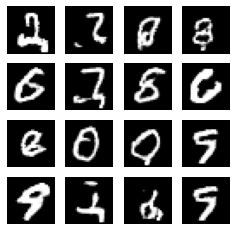

Epoch 96/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6097 - g_loss: 0.9637


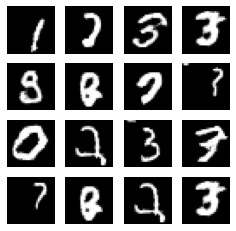

Epoch 97/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6113 - g_loss: 0.9738


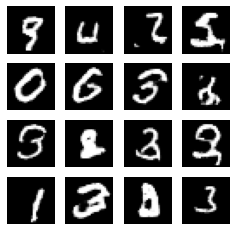

Epoch 98/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6059 - g_loss: 0.9701


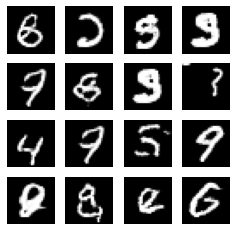

Epoch 99/500
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6129 - g_loss: 0.9566


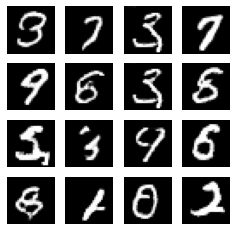

Epoch 100/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6113 - g_loss: 0.9671


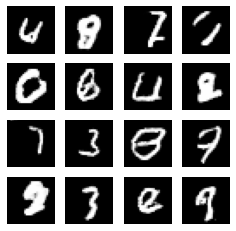

Epoch 101/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6103 - g_loss: 0.9699


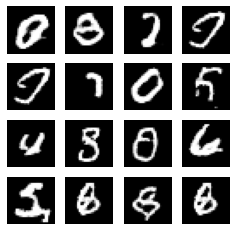

Epoch 102/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6084 - g_loss: 0.9714


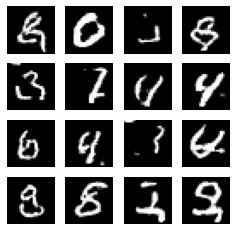

Epoch 103/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6095 - g_loss: 0.9664


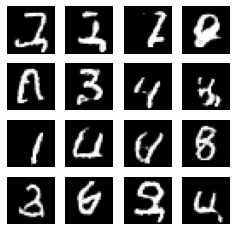

Epoch 104/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6090 - g_loss: 0.9627


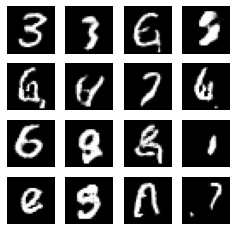

Epoch 105/500
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6118 - g_loss: 0.9685


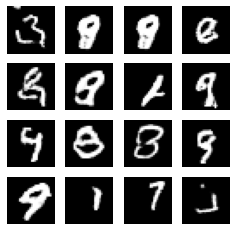

Epoch 106/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6120 - g_loss: 0.9737


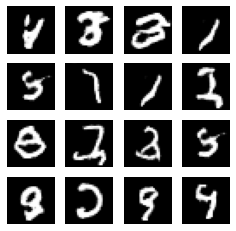

Epoch 107/500
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6078 - g_loss: 0.9613


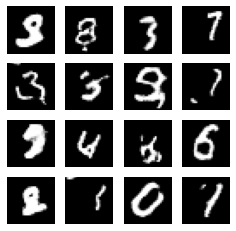

Epoch 108/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6118 - g_loss: 0.9634


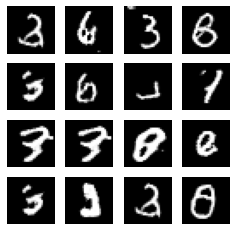

Epoch 109/500
100/100 [==============================] - 4s 38ms/step - d_loss: 0.6113 - g_loss: 0.9666


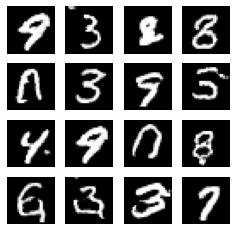

Epoch 110/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6064 - g_loss: 0.9754


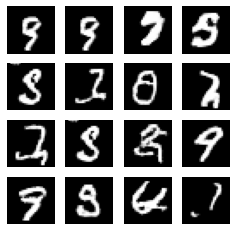

Epoch 111/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6087 - g_loss: 0.9749


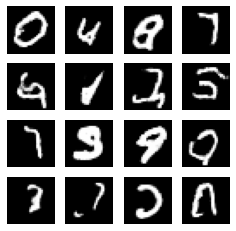

Epoch 112/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6075 - g_loss: 0.9734


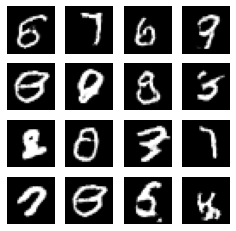

Epoch 113/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6095 - g_loss: 0.9668


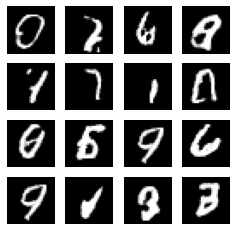

Epoch 114/500
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6105 - g_loss: 0.9699


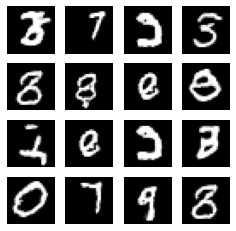

Epoch 115/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6058 - g_loss: 0.9620


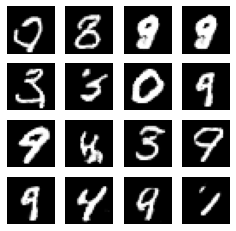

Epoch 116/500
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6086 - g_loss: 0.9686


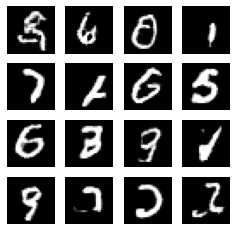

Epoch 117/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6087 - g_loss: 0.9722


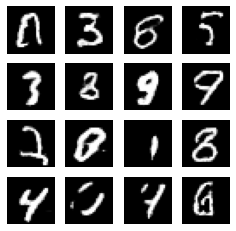

Epoch 118/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6068 - g_loss: 0.9716


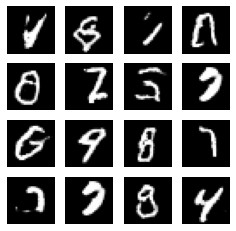

Epoch 119/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6082 - g_loss: 0.9718


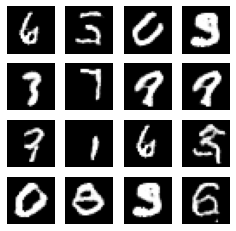

Epoch 120/500
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6076 - g_loss: 0.9725


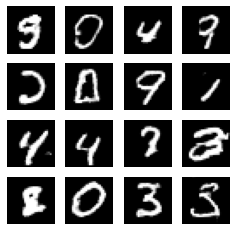

Epoch 121/500
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6088 - g_loss: 0.9697


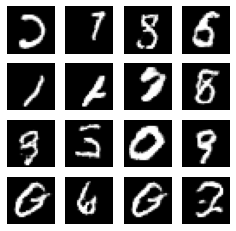

Epoch 122/500
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6081 - g_loss: 0.9652


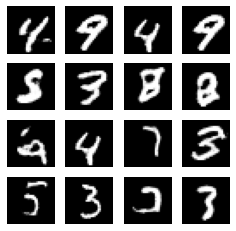

Epoch 123/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6120 - g_loss: 0.9663


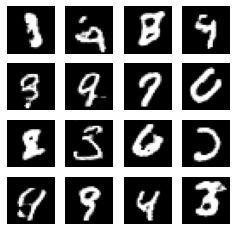

Epoch 124/500
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6140 - g_loss: 0.9669


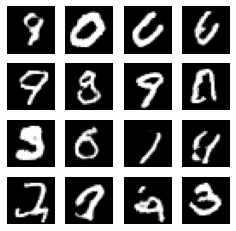

Epoch 125/500
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6095 - g_loss: 0.9679


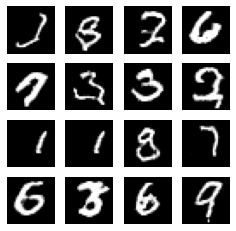

Epoch 126/500
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6121 - g_loss: 0.9557


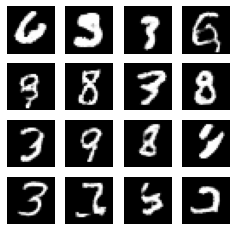

Epoch 127/500
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6122 - g_loss: 0.9703


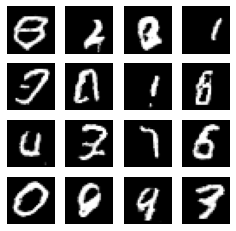

Epoch 128/500
100/100 [==============================] - 6s 56ms/step - d_loss: 0.6109 - g_loss: 0.9709


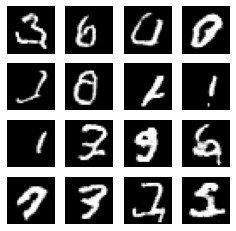

Epoch 129/500
100/100 [==============================] - 8s 76ms/step - d_loss: 0.6101 - g_loss: 0.9689


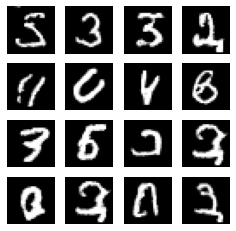

Epoch 130/500
100/100 [==============================] - 8s 60ms/step - d_loss: 0.6112 - g_loss: 0.9753


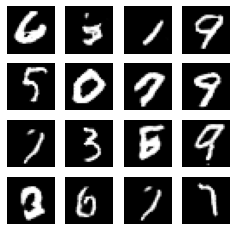

Epoch 131/500
100/100 [==============================] - 6s 60ms/step - d_loss: 0.6129 - g_loss: 0.9681


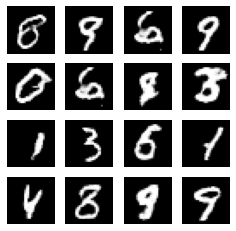

Epoch 132/500
100/100 [==============================] - 9s 75ms/step - d_loss: 0.6106 - g_loss: 0.9717


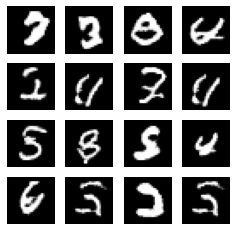

Epoch 133/500
100/100 [==============================] - 7s 74ms/step - d_loss: 0.6091 - g_loss: 0.9597


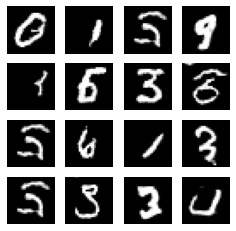

Epoch 134/500
100/100 [==============================] - 7s 75ms/step - d_loss: 0.6084 - g_loss: 0.9609


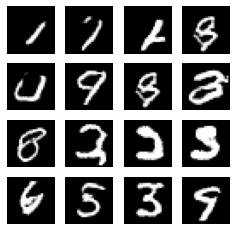

Epoch 135/500
100/100 [==============================] - 7s 60ms/step - d_loss: 0.6130 - g_loss: 0.9664


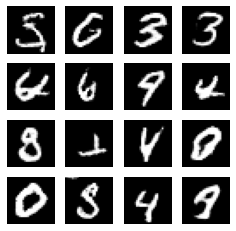

Epoch 136/500
100/100 [==============================] - 9s 75ms/step - d_loss: 0.6120 - g_loss: 0.9615


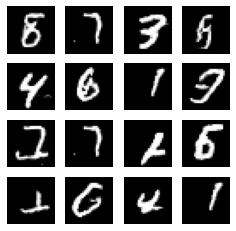

Epoch 137/500
100/100 [==============================] - 7s 74ms/step - d_loss: 0.6106 - g_loss: 0.9715


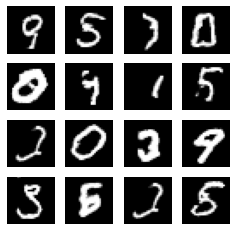

Epoch 138/500
 61/100 [=================>............] - ETA: 3s - d_loss: 0.6094 - g_loss: 0.9729

KeyboardInterrupt: 

In [122]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 128
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

logdir = 'gan-logdir/tf_mnist/'
isaveimg = SaveImagesCallback(logdir= logdir)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, batch_size= batch_size)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(100), epochs=500, callbacks= [isaveimg])